# *Trabajo Práctico N°1*

**Cerrato Brown Juan Marcos, Fontecha María Eugenia, Dip Federico**




#Librerías

---
Carga de librerías


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import pickle

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:

%cd /content/drive/My Drive/Redes Neuronales

!ls

#Carga de datos

---
Esta sección comprende la carga de datos train_data, valid_data y test_data. Se analizó la proporción de los 3 subsets, se decidió unir el subset de train y el de validación, para luego aumentar la proporción de datos para validación a un 20 %.


In [ ]:
df_train = pd.read_hdf("train_data.hdf5")
df_valid = pd.read_hdf("valid_data.hdf5")
df_test = pd.read_hdf("test_data.hdf5")

In [ ]:
#Proporción de los 3 subsets
n_train = len(df_train)
n_val = len(df_valid)
n_test=len(df_test)

print("El ", 100*n_train/(n_train+n_val+n_test), "% de los datos del dataset conforman el subset TRAIN.")
print("El ", 100*n_val/(n_train+n_val+n_test), "% de los datos del dataset conforman el subset VALIDATION.")
print("El ", 100*n_test/(n_train+n_val+n_test), "% de los datos del dataset conforman el subset TEST.")

El  96.54396142227252 % de los datos del dataset conforman el subset TRAIN.
El  1.7296009194545834 % de los datos del dataset conforman el subset VALIDATION.
El  1.7264376582728946 % de los datos del dataset conforman el subset TEST.


Combinamos el set de train y valid para redividirlos en proporción 80/20

In [ ]:
df_test.reset_index(drop=True, inplace = True)
df = pd.concat([df_train, df_valid], ignore_index = True) #unimos train y valid para re-dividir.
df.head()

,gold_label,text
0,contradiction,they are inside of a house
1,entailment,two guys are in a yard
2,neutral,They are doing yardwork
3,contradiction,A man is swimming.
4,entailment,Two young white men are near some bushes.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['gold_label'], test_size=0.2, random_state=42)

In [ ]:
#Nueva proporción de los 3 subsets
n_train = len(X_train)
n_val = len(X_val)
n_test=len(df_test)

print("El ", 100*n_train/(n_train+n_val+n_test), "% de los datos del dataset conforman el subset TRAIN.")
print("El ", 100*n_val/(n_train+n_val+n_test), "% de los datos del dataset conforman el subset VALIDATION.")
print("El ", 100*n_test/(n_train+n_val+n_test), "% de los datos del dataset conforman el subset TEST.")

El  78.61881472603523 % de los datos del dataset conforman el subset TRAIN.
El  19.654747615691885 % de los datos del dataset conforman el subset VALIDATION.
El  1.7264376582728946 % de los datos del dataset conforman el subset TEST.


#Balance de clases

---
Observamos que el dataset se encuentra balanceado en cuanto a proporción de clases, por lo que esperaríamos clasificar cada clase con una precisión de aproximadamente 0.33, si suponemos que el dataset no está sesgado.


In [ ]:
#Balance de clases
from collections import Counter
prop=Counter(y_train)
total=prop['contradiction']+prop['entailment']+prop['neutral']

print("La cantidad de 'contradiction' es ", prop['contradiction'] , "y representa el ", 100*prop['contradiction']/total, "% del total del dataset de train")
print("La cantidad de 'entailment' es ", prop['entailment'] , "y representa el ", 100*prop['entailment']/total, "% del total del dataset de train")
print("La cantidad de 'neutral' es ", prop['neutral'] , "y representa el ", 100*prop['neutral']/total, "% del total del dataset de train")




#contradiction, entailment, neutral

La cantidad de 'contradiction' es  148953 y representa el  33.29548223270827 % del total del dataset de train
La cantidad de 'entailment' es  149628 y representa el  33.44636506492432 % del total del dataset de train
La cantidad de 'neutral' es  148786 y representa el  33.258152702367404 % del total del dataset de train


#Preprocesamiento

---
Utilizaremos tres estrategias diferentes de preprocesamiento y evaluaremos cuál resulta más efectiva para el modelo.



*   Preprocesamiento nulo
*   Lemmatizer
*   Lemmatizer + Stemmer + Filtrado de stopwords y puntuación


## Preprocesado y guardado de archivos

---
Realizamos dicho preprocesamiento y guardamos los archivos como .pck para futuras pruebas


In [ ]:
#tokenización
#lematización
#puntuación, stop words
#stemización
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

lem_train = []
stem_stop_train = []

for i in X_train:  
  
  tok = word_tokenize(i)

  lem = [lemmatizer.lemmatize(x, pos='v') for x in tok]
  lem_train.append(" ".join(lem))

  punc = [x for x in lem if x not in punctuation]
  stop = [x for x in punc if x not in stop_words]
  stem = [stemmer.stem(x) for x in stop]
  stem_stop_train.append(" ".join(stem))

lem_val = []
stem_stop_val = []

for i in X_val:  
  
  tok = word_tokenize(i)

  lem = [lemmatizer.lemmatize(x, pos='v') for x in tok]
  lem_val.append(" ".join(lem))

  punc = [x for x in lem if x not in punctuation]
  stop = [x for x in punc if x not in stop_words]
  stem = [stemmer.stem(x) for x in stop]
  stem_stop_val.append(" ".join(stem))

lem_test = []
stem_stop_test = []

for i in df_test['text']:

  tok = word_tokenize(i)

  lem = [lemmatizer.lemmatize(x, pos='v') for x in tok]
  lem_test.append(" ".join(lem))

  punc = [x for x in lem if x not in punctuation]
  stop = [x for x in punc if x not in stop_words]
  stem = [stemmer.stem(x) for x in stop]
  stem_stop_test.append(" ".join(stem))

with open('lem_train.pck', 'wb') as fp:
    pickle.dump(lem_train, fp)

with open('lem_val.pck', 'wb') as fp:
    pickle.dump(lem_val, fp)

with open('lem_test.pck', 'wb') as fp:
    pickle.dump(lem_test, fp)

with open('stem_stop_train.pck', 'wb') as fp:
    pickle.dump(stem_stop_train, fp)

with open('stem_stop_val.pck', 'wb') as fp:
    pickle.dump(stem_stop_val, fp)

with open('stem_stop_test.pck', 'wb') as fp:
    pickle.dump(stem_stop_test, fp)

## Carga de archivos preprocesados

In [ ]:
with open ('lem_train.pck', 'rb') as fp:
    lem_train = pickle.load(fp)

with open ('lem_val.pck', 'rb') as fp:
    lem_val = pickle.load(fp)

with open ('lem_test.pck', 'rb') as fp:
    lem_test = pickle.load(fp)

with open ('stem_stop_train.pck', 'rb') as fp:
    stem_stop_train = pickle.load(fp)

with open ('stem_stop_val.pck', 'rb') as fp:
    stem_stop_val = pickle.load(fp)

with open ('stem_stop_test.pck', 'rb') as fp:
    stem_stop_test = pickle.load(fp)

#Naive Bayes Multinomial

---

## Búsqueda de hiperparámetros 

---

Búsqueda de mejores hiperparámetros para Naive Bayes Multinomial con RandomizedSearch de 15 iteraciones y 5-fold cross validation.

La 5-fold cross validation es una técnica de validación que consiste en dividir el set de train en 5 subsets y realizar 5 iteraciones de entrenamiento y validación, donde en cada iteración se utiliza un subset diferente para el hold-out.

Los hiperparámetros a analizar serán los siguientes:

Hiperarámetros:


*   max_df (CV): [0.6, 0.8]
*   n-grams (CV): [1,  [1 2], [1 4]]
*   Tfidf: [True, False]
*   alfa (NB): [0.001, 0.1,  0.5]


## Definimos el pipeline y los hiperparámetros

In [ ]:
from pprint import pprint
from time import time
import logging

In [ ]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [ ]:
# Definimos un a pipeline combinando el extractor de características y el clasificador
#CV + TFIDF + MNB
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__max_df': ( 0.6, 0.8),
    'vect__ngram_range': ((1, 1), (1, 2), (1,4)),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.001, 0.1, 0.5),
    
}

## Modelo 1: sin preprocesamiento

In [ ]:
rand_search1 = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, n_iter = 15, cv = 5, return_train_score = True)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
rand_search1.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % rand_search1.best_score_)
print("Best parameters set:")
best_parameters = rand_search1.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.001, 0.1, 0.5),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.6, 0.8),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 4))}
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 21.6min finished


done in 1315.972s

Best score: 0.630
Best parameters set:
	clf__alpha: 0.5
	tfidf__use_idf: True
	vect__max_df: 0.6
	vect__ngram_range: (1, 2)


In [ ]:
results_df1 = pd.DataFrame(rand_search1.cv_results_)
results_df1 = results_df1.sort_values(by=['rank_test_score'])
results_df1 = (
    results_df1
    .set_index(results_df1["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df1[
    ['rank_test_score', 'mean_test_score', 'mean_train_score', 'std_test_score']
]

,rank_test_score,mean_test_score,mean_train_score,std_test_score
kernel,,,,
"(1, 2)_0.6_True_0.5",1,0.629617,0.745203,0.001186
"(1, 4)_0.8_False_0.5",2,0.626899,0.794748,0.001177
"(1, 4)_0.8_True_0.5",3,0.624744,0.850976,0.001602
"(1, 2)_0.8_True_0.1",4,0.621932,0.786207,0.001478
"(1, 4)_0.8_False_0.1",5,0.620844,0.872569,0.001919
"(1, 1)_0.6_False_0.5",6,0.614341,0.637104,0.001715
"(1, 1)_0.8_False_0.5",6,0.614341,0.637104,0.001715
"(1, 1)_0.6_False_0.1",8,0.613961,0.645132,0.001736
"(1, 4)_0.6_True_0.1",9,0.612830,0.904891,0.001776


El mejor modelo tuvo un score de 0.629617 y se obtuvo con:


*   vect__max_df: 0.6
*   vect__ngram_range: (1, 2)
*   tfidf__use_idf: True
*   alfa: 0.5






Graficamos el área bajo la curva por fold para cada modelo entrenado

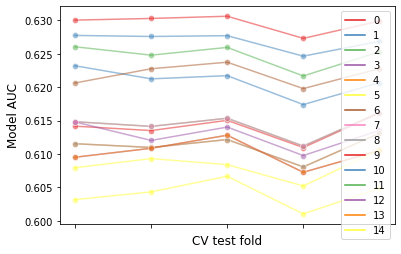

In [ ]:
results_df1 = pd.DataFrame(rand_search1.cv_results_)
# create df of model scores ordered by performance
model_scores = results_df1.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

Probamos el modelo con el set de validación y calculamos métricas

* Precisión o valor predictivo positivo: $\frac{VP}{VP+FP}$
* Recall o sensibilidad: $\frac{VP}{VP+FN}$
* f1-score: $2\cdot\frac{precision \cdot recall}{precision + recall}$
* support: total de clasficaciones para esa clase 

In [ ]:
y_true, y_pred = y_val, rand_search1.predict(X_val)
print(classification_report(y_true, y_pred, digits = 4))
print()

               precision    recall  f1-score   support

contradiction     0.6493    0.6308    0.6399     37512
   entailment     0.6138    0.6691    0.6402     37117
      neutral     0.6460    0.6065    0.6256     37213

     accuracy                         0.6354    111842
    macro avg     0.6364    0.6355    0.6353    111842
 weighted avg     0.6364    0.6354    0.6353    111842




Se obtuvo una accuracy de 63,54%

In [ ]:
pd.DataFrame(confusion_matrix(y_true,y_pred), index = rand_search1.classes_, columns = rand_search1.classes_)

,contradiction,entailment,neutral
contradiction,23662,7447,6403
entailment,6318,24834,5965
neutral,6465,8178,22570


## Modelo 2: con Lemmatizer

In [ ]:
results_df2 = pd.DataFrame(rand_search2.cv_results_)
results_df2 = results_df2.sort_values(by=['rank_test_score'])
results_df2 = (
    results_df2
    .set_index(results_df2["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df2[
    ['rank_test_score', 'mean_test_score', 'mean_train_score', 'std_test_score']
]

,rank_test_score,mean_test_score,mean_train_score,std_test_score
kernel,,,,
"(1, 2)_0.8_True_0.5",1,0.631839,0.731827,0.001143
"(1, 2)_0.8_False_0.5",2,0.629369,0.691893,0.001230
"(1, 2)_0.6_False_0.1",3,0.629020,0.733655,0.000927
"(1, 2)_0.8_False_0.1",4,0.629014,0.733215,0.000976
"(1, 4)_0.8_True_0.5",5,0.628493,0.838377,0.000947
"(1, 4)_0.6_True_0.5",6,0.628488,0.838381,0.000911
"(1, 2)_0.6_True_0.1",7,0.624293,0.768386,0.001881
"(1, 4)_0.8_True_0.1",8,0.617547,0.894062,0.001584
"(1, 2)_0.8_False_0.001",9,0.613510,0.779500,0.001788


El mejor modelo tuvo un score de 0.631839 y se obtuvo con:


*   vect__max_df: 0.8
*   vect__ngram_range: (1, 2)
*   tfidf__use_idf: True
*   alfa: 0.5






Graficamos el área bajo la curva por fold para cada modelo entrenado

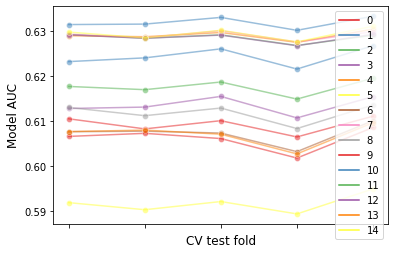

In [ ]:
results_df2 = pd.DataFrame(rand_search2.cv_results_)
# create df of model scores ordered by performance
model_scores = results_df2.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

Probamos el modelo con el set de validación y calculamos métricas

In [ ]:
y_true, y_pred = y_val, rand_search2.predict(lem_val)
print(classification_report(y_true, y_pred, digits=4))
print()

               precision    recall  f1-score   support

contradiction     0.6494    0.6271    0.6381     37512
   entailment     0.6138    0.6749    0.6429     37117
      neutral     0.6487    0.6068    0.6270     37213

     accuracy                         0.6362    111842
    macro avg     0.6373    0.6363    0.6360    111842
 weighted avg     0.6374    0.6362    0.6360    111842




Se obtuvo una accuracy de 63.62%

In [ ]:
pd.DataFrame(confusion_matrix(y_true,y_pred), index = rand_search2.classes_, columns = rand_search2.classes_)

,contradiction,entailment,neutral
contradiction,23524,7570,6418
entailment,6257,25050,5810
neutral,6443,8190,22580


## Modelo 3: lemmatizer + stemmer + stopwords + puntuación

In [ ]:
rand_search3 = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, n_iter = 15, cv = 5, return_train_score = True)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
rand_search3.fit(stem_stop_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % rand_search3.best_score_)
print("Best parameters set:")
best_parameters = rand_search3.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.001, 0.1, 0.5),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.6, 0.8),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 4))}
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 19.2min finished


done in 1169.292s

Best score: 0.614
Best parameters set:
	clf__alpha: 0.5
	tfidf__use_idf: False
	vect__max_df: 0.6
	vect__ngram_range: (1, 2)


In [ ]:
results_df3 = pd.DataFrame(rand_search3.cv_results_)
results_df3 = results_df3.sort_values(by=['rank_test_score'])
results_df3 = (
    results_df3
    .set_index(results_df3["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df3[
    ['rank_test_score', 'mean_test_score', 'mean_train_score', 'std_test_score']
]

,rank_test_score,mean_test_score,mean_train_score,std_test_score
kernel,,,,
"(1, 2)_0.6_False_0.5",1,0.613561,0.715151,0.001575
"(1, 2)_0.6_True_0.5",2,0.612370,0.761149,0.001251
"(1, 2)_0.8_True_0.5",2,0.612370,0.761149,0.001251
"(1, 4)_0.8_False_0.5",4,0.610950,0.808628,0.001322
"(1, 2)_0.6_True_0.1",5,0.603516,0.804179,0.001427
"(1, 4)_0.8_False_0.1",6,0.601533,0.882028,0.001286
"(1, 1)_0.8_False_0.5",7,0.599175,0.617599,0.002136
"(1, 1)_0.6_False_0.1",8,0.598504,0.622565,0.002023
"(1, 1)_0.6_False_0.001",9,0.597243,0.624484,0.002103


El mejor modelo tuvo un score de 0.613561 y se obtuvo con:


*   vect__max_df: 0.6
*   vect__ngram_range: (1, 2)
*   tfidf__use_idf: False
*   alfa: 0.5






Graficamos el área bajo la curva por fold para cada modelo entrenado

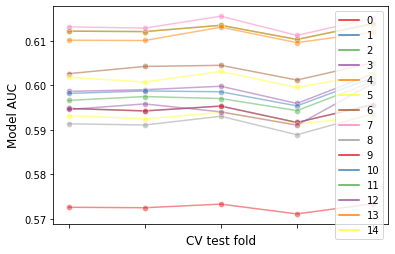

In [ ]:
results_df3 = pd.DataFrame(rand_search3.cv_results_)
# create df of model scores ordered by performance
model_scores = results_df3.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

Probamos el modelo con el set de validación y calculamos métricas

In [ ]:
y_true, y_pred = y_val, rand_search3.predict(stem_stop_val)
print(classification_report(y_true, y_pred, digits=4))
print()

               precision    recall  f1-score   support

contradiction     0.6334    0.6152    0.6242     37512
   entailment     0.5980    0.6581    0.6266     37117
      neutral     0.6227    0.5783    0.5997     37213

     accuracy                         0.6172    111842
    macro avg     0.6180    0.6172    0.6168    111842
 weighted avg     0.6181    0.6172    0.6168    111842




Se obtuvo una accuracy de 61.72%

In [ ]:
pd.DataFrame(confusion_matrix(y_true,y_pred), index = rand_search3.classes_, columns = rand_search3.classes_)

,contradiction,entailment,neutral
contradiction,23524,7570,6418
entailment,6257,25050,5810
neutral,6443,8190,22580


#Conclusiones
---

En primer lugar, podemos concluir que el dataset está sesgado ya que, teniendo en cuenta únicamente las hipótesis, logramos generar modelos capaces de predecir la clase correspondiente con una accuracy mayor al 60% en la mayoría de los casos. Dado que estos modelos ignoran cuál es la premisa correspondiente a cada hipótesis, un dataset no sesgado no debería ser capaz de alcanzar una accuracy mayor a la de un modelo que clasifique al azar, es decir, del 33% aproximadamente, es decir, la proporción de las tres clases en el dataset.

Por otro lado, tanto en Naive Bayes como en MLP el mejor modelo obtenido fue aquel en el que el preprocesamiento consistión únicamente de la lematización. Consideramos que esto tiene que ver con que un preprocesamiento más exhaustivo podría estar generando una pérdida de información, especialmente en la estructura de la hipóstesis. En el caso del preprocesamiento nulo, este obtuvo resultados que si bien menores, fueron muy similares a los de los modelos con lematización.

En cuanto a los hiperparámetros evaluados para Naive Bayes se encontró que en general el método de extracción de características por TfIdf arrojó mejores resultados que el de Count Vectorizer. A su vez, en todos los casos utilizar n-grams de 1 y 2 también resultó dar mejor score. Por último, el mejor alfa fue de 0.5.

El mejor modelo de MLP se obtuvo con tres capas, con diez neuronas en las primeras dos capas y tres en la capa de salida. La función de activación fue la 'relu' para las capas 1 y 2 y la 'softmax' para la capa 3. El batch_size utilizado fue de 50. Se logró un accuracy de 0.6420.

Finalmente, como comparación general entre ambos modelos, con MLP se obtuvo una accuracy mayor que con Naive Bayes, utilizando el mismo preprocesamiento.
